In [178]:
import numpy as np
import pandas as pd

In [204]:
def read_xams_sc(fn, fn_header='/data/xenon/xams/run8/SC_headers/20-3-2017', properties=None, max_entries = 1e5):
    i = 0
    with open(fn_header, 'r') as f:
        for line in f:
            line = line.split(sep='\n')[0]
            properties_list = line.split(sep='\t')
    
    if properties:
        try:
            selected_entries = [np.where(np.array(properties_list) == prop)[0][0] for prop in properties]
        except IndexError:
            print('Could not find property, you can choose from this list:')
            print(properties_list)
    else:
        selected_entries = [i for i in range(len(properties_list))]
        properties = properties_list

    dt = [(name, float) if name != 'date - time' else (name, str, 20) for name in properties]
    
    
    d = np.zeros(max_entries, dtype= dt)
    error_lines = []
    with open(fn, 'r') as f:
        for line in f:
            
            line = line.split(sep='\t')
            
            for name, ent in zip(properties, selected_entries):
                try:
                    d[name][i] = line[ent]
                except:
                    if i not in error_lines:
                        error_lines.append(i)
                        print('Error line %d, skipping it...' % i)
                    d[name][i] = 0

            i += 1

            if i > max_entries:
                print('User-defined max_entries reached, turn it up to read full dataset!')
            
    d = d[:i]
    
    non_error = np.array([True if i not in error_lines else False for i in range(len(d))])
    n_err = len(d[np.invert(non_error)])
    if n_err > 0:
        print('Removing a total of %d lines due to errors.' % n_err)
    
    d = pd.DataFrame(d[non_error])
    
    if 'Timestamp' in properties:
        d['unix_time'] = d['Timestamp'] - 2082844800
                        
    return d

### Example

In [205]:
fn = '/data/xenon/xams/run8/SC_data/28-3-2017'

In [206]:
d = read_xams_sc(fn, fn_header='/data/xenon/xams/run8/SC_headers/20-3-2017')
                 #properties=['date - time', 'Pdetector', 'Level', 'Timestamp', 'Flow', 'A'])

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
time.

In [203]:
# https://www.epochconverter.com/mac
# The difference between the Unix timestamp epoch (1970) 
# and the Mac timestamp epoch (1904) is 2082844800 seconds. 

In [202]:
d['Timestamp'].values[0]

3573496800.5050001

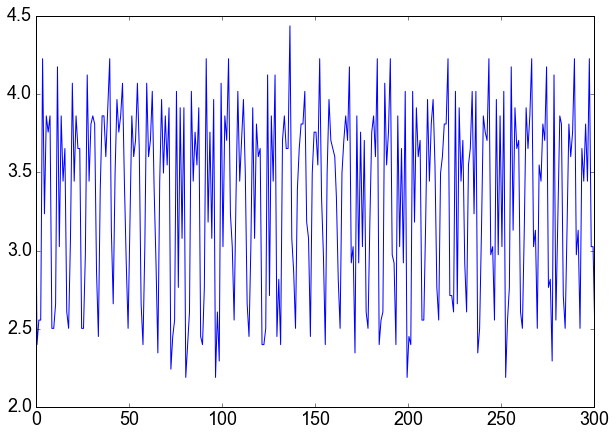

In [213]:
d['time_since_start'] = d['unix_time'] - 1490712750

plt.plot(d['time_since_start'], d['Flow'])
#plt.xlim(58.5e3, 59.2e3)
plt.xlim(0, 300)
plt.ylim(2, 4.5)
plt.show()

